Saving 2.jpg to 2.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 132MB/s]


Number of detections: 1
COCO annotations ready.
loading annotations into memory...
Done (t=1.10s)
creating index...
index created!


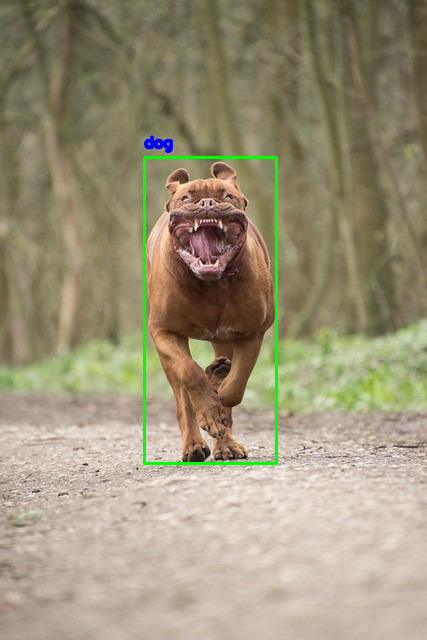

In [1]:
import torch
import torchvision
from torchvision import transforms as T
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import os
import requests
import zipfile
from pycocotools.coco import COCO

# Step 1: Upload Image File Manually
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # Get uploaded filename

# Step 2: Load and Process the Image
img = Image.open(filename).convert("RGB")
transform = T.ToTensor()
image = transform(img)

# Step 3: Load Pre-trained Faster R-CNN Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Step 4: Run Inference
with torch.no_grad():
    prediction = model([image])

# Extract Predictions
boxes, labels, scores = prediction[0]["boxes"], prediction[0]["labels"], prediction[0]["scores"]

# Filter Predictions with Confidence > 0.5
num = torch.sum(scores > 0.5).item()
print("Number of detections:", num)

# Step 5: Download COCO Annotations Automatically (if not present)
coco_annotation_path = "/content/instances_val2017.json"

if not os.path.exists(coco_annotation_path):
    print("Downloading COCO annotations...")
    url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    coco_zip_path = "/content/coco_annotations.zip"

    # Download the COCO annotations
    r = requests.get(url, stream=True)
    with open(coco_zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            f.write(chunk)

    # Extract only the needed annotation file
    with zipfile.ZipFile(coco_zip_path, "r") as zip_ref:
        zip_ref.extract("annotations/instances_val2017.json", "/content/")
        os.rename("/content/annotations/instances_val2017.json", coco_annotation_path)

    # Cleanup
    os.remove(coco_zip_path)
    os.rmdir("/content/annotations")

print("COCO annotations ready.")

# Step 6: Load COCO Metadata
coco = COCO(coco_annotation_path)
coco_categories = coco.loadCats(coco.getCatIds())
coco_names = {cat["id"]: cat["name"] for cat in coco_categories}

# Step 7: Load Image with OpenCV
img_read = cv2.imread(filename)
font = cv2.FONT_HERSHEY_SIMPLEX

# Step 8: Draw Bounding Boxes and Labels
for i in range(num):
    x1, y1, x2, y2 = boxes[i].numpy().astype(int)

    # Get Label from COCO Dataset
    label_idx = int(labels[i].item())
    class_name = coco_names.get(label_idx, "Unknown")  # Fetch from COCO

    # Draw Bounding Box and Label
    cv2.rectangle(img_read, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_read, class_name, (x1, y1 - 10), font, 0.5, (255, 0, 0), 2, cv2.LINE_AA)

# Step 9: Display the Image with Detections
cv2_imshow(img_read)